In [54]:
import numpy as np
from matplotlib import pyplot as plt

In [3]:
def extract_patch(img, x, y, p):
    return img[x : x + p, y : y + p]

In [4]:
def l1(p1, p2):
    return np.sum(abs(p1 - p2))

In [5]:
def l2(p1, p2):
    return np.sum((p1 - p2) ** 2) ** 0.5

In [68]:
def propagation(img, nnf_x, nnf_y, odd, p, loss_fn=l1):
    h, w = img.shape[0] - p, img.shape[1] - p
    if odd:
        for x in range(0, h-1):
            for y in range(0,w-1):
                best_d = nnf_x[x, y], nnf_y[x, y]
                best_l = loss_fn(extract_patch(img, x, y, p), extract_patch(img, x + nnf_x[x, y], y + nnf_y[x, y], p))
                if 0 <= x + nnf_x[x+1, y] < h and 0 <= y + nnf_y[x+1, y] < w and loss_fn(extract_patch(img, x, y, p), extract_patch(img, x + nnf_x[x+1, y], y + nnf_y[x+1, y], p)) < best_l:
                    best_l = loss_fn(extract_patch(img, x, y, p), extract_patch(img, x + nnf_x[x+1, y], y + nnf_y[x+1, y], p))
                    best_d = nnf_x[x+1, y], nnf_y[x+1, y]
                if 0 <= x + nnf_x[x, y+1] < h and 0 <= y + nnf_y[x, y+1] < w and loss_fn(extract_patch(img, x + best_d[0], y + best_d[1], p), extract_patch(img, x + nnf_x[x, y+1], y + nnf_y[x, y+1], p)) < best_l:
                    best_l = loss_fn(extract_patch(img, x, y, p), extract_patch(img, x + nnf_x[x, y+1], y + nnf_y[x, y+1], p))
                    best_d = nnf_x[x, y+1], nnf_y[x, y+1]
                nnf_x[x, y], nnf_y[x, y] = best_d
    else:
        for x in range(1, h):
            for y in range(1,w):
                best_d = nnf_x[x, y], nnf_y[x, y]
                best_l = loss_fn(extract_patch(img, x, y, p), extract_patch(img, x + nnf_x[x, y], y + nnf_y[x, y], p))
                if 0 <= x + nnf_x[x-1, y] < h and 0 <= y + nnf_y[x-1, y] < w and loss_fn(extract_patch(img, x, y, p), extract_patch(img, x + nnf_x[x-1, y], y + nnf_y[x-1, y], p)) < best_l:
                    best_l = loss_fn(extract_patch(img, x, y, p), extract_patch(img, x + nnf_x[x-1, y], y + nnf_y[x-1, y], p))
                    best_d = nnf_x[x-1, y], nnf_y[x-1, y]
                if 0 <= x + nnf_x[x, y-1] < h and 0 <= y + nnf_y[x, y-1] < w and loss_fn(extract_patch(img, x + best_d[0], y + best_d[1], p), extract_patch(img, x + nnf_x[x, y-1], y + nnf_y[x, y-1], p)) < best_l:
                    best_l = loss_fn(extract_patch(img, x, y, p), extract_patch(img, x + nnf_x[x, y-1], y + nnf_y[x, y-1], p))
                    best_d = nnf_x[x, y-1], nnf_y[x, y-1]
                nnf_x[x, y], nnf_y[x, y] = best_d
    return nnf_x, nnf_y
                                     
                                     
                                     
                                     
                                     

In [110]:
def random_search(img, nnf_x, nnf_y, p, L=5, loss_fn=l1):
    dir_random = [(-1,-1), (0,1), (1,0), (0,-1), (-1,0), (1,-1), (-1,1), (1,1)]
    h, w = img.shape[0] - p, img.shape[1] - p
    for x in range(h):
        for y in range(w):
            best_d = nnf_x[x, y], nnf_y[x, y]
            best_l = loss_fn(extract_patch(img, x, y, p), extract_patch(img, x + nnf_x[x, y], y + nnf_y[x, y], p))
            for i in range(L):
                dir_ = dir_random[np.random.randint(8)]
                while not(0 <= x + nnf_x[x ,y] + 2 ** i * dir_[0] < h) or not(0 <= y + nnf_y[x ,y] + 2 ** i * dir_[1] < w) or (nnf_x[x ,y] + 2 ** i * dir_[0] == 0 and nnf_y[x ,y] + 2 ** i * dir_[1]==0):
                    dir_ = dir_random[np.random.randint(8)]
                if loss_fn(extract_patch(img, x, y, p), extract_patch(img, int(x + nnf_x[x, y] + 2 ** i * dir_[0]), int(y + nnf_y[x, y] + 2 ** i * dir_[1]), p)) < best_l:
                    best_d = nnf_x[x ,y] + 2 ** i * dir_[0], nnf_y[x ,y] + 2 ** i * dir_[1]
            nnf_x[x, y], nnf_y[x, y] = best_d
    return nnf_x, nnf_y
                
            

In [111]:
def remove_0(nnf_x, nnf_y, p):
    for i in range(nnf_x.shape[0]):
        for j in range(nnf_x.shape[1]):
            while nnf_x[i,j] == nnf_y[i,j] == 0:
                nnf_x[i,j] = np.random.randint(-i, nnf_x.shape[0] - i - p)
    return nnf_x, nnf_y

In [112]:
def patchmatch(img, n_iters=100, p=8):
    h, w = img.shape[0] - p, img.shape[1] - p
    x = np.array(np.linspace(0,h-1,h))
    y = np.array(np.linspace(0,w-1,w))
    yy, xx = np.meshgrid(x, y)
    xx = xx.astype(int)
    yy = yy.astype(int)
    nnf_x = np.random.randint(-xx, h-xx-p)
    nnf_y = np.random.randint(-yy, w-yy-p)
    nnf_x, nnf_y = remove_0(nnf_x, nnf_y, p) # to avoid null move
    for i in range(n_iters):
        print(i)
        nnf_x, nnf_y = propagation(img, nnf_x, nnf_y, i%2, p)
        nnf_x, nnf_y = random_search(img, nnf_x, nnf_y, p)
    return nnf_x, nnf_y

In [156]:
img = np.random.randint(0,256, size=(40,40))
img[2:15, 4:17] = img[11:24, 20:33] 

In [164]:
nnf_x, nnf_y = patchmatch(img, 150, p=8)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


In [165]:
nnf_x[2:10, 4:12]

array([[9, 9, 9, 9, 9, 9, 9, 9],
       [9, 9, 9, 9, 9, 9, 9, 9],
       [9, 9, 9, 9, 9, 9, 9, 9],
       [9, 9, 9, 9, 9, 9, 9, 9],
       [9, 9, 9, 9, 9, 9, 9, 9],
       [9, 9, 9, 9, 9, 9, 9, 9],
       [9, 9, 9, 9, 9, 9, 9, 9],
       [9, 9, 9, 9, 9, 9, 9, 9]])

In [166]:
nnf_y[2:10, 4:12]

array([[16, 16, 16, 16, 16, 16, 16, 16],
       [16, 16, 16, 16, 16, 16, 16, 16],
       [16, 16, 16, 16, 16, 16, 16, 16],
       [16, 16, 16, 16, 16, 16, 16, 16],
       [16, 16, 16, 16, 16, 16, 16, 16],
       [16, 16, 16, 16, 16, 16, 16, 16],
       [16, 16, 16, 16, 16, 16, 16, 16],
       [16, 16, 16, 16, 16, 16, 16, 16]])

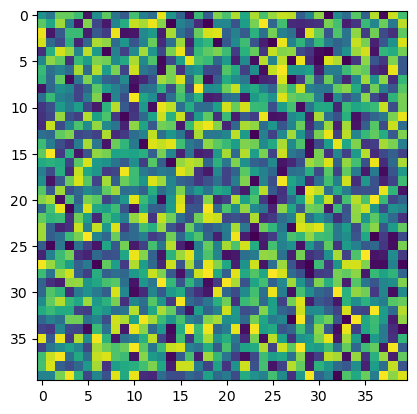

In [167]:
plt.imshow(img, interpolation='nearest')
plt.show()